# Classification Training Pipeline

This notebook implements a complete Graph Neural Network (GNN) pipeline for a 3-class classification task (`Low`, `Medium`, `High`).  It now includes additional metrics in hyperparameter tuning and enhanced model comparison visualizations.

## Table of Contents
1. [Environment & Setup](#step1)
2. [Model Definition](#step2)
3. [Evaluation Function](#step3)
4. [Hyperparameter Sweep (10-Fold CV)](#step4)
5. [Retraining & Validation (10-Fold CV)](#step5)
6. [Cross-Validation Results Visualization](#step6)
7. [Ensemble Averaging](#step7)
8. [Final Model Training & Test Evaluation](#step8)
9. [Baseline QSAR Comparison](#step9)

---

## Prerequisites
- PyTorch & PyTorch Geometric  
- scikit-learn  
- pandas, numpy, matplotlib  
- RDKit (only for feature extraction)  
- GPU recommended

Install requirements:
```bash
pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi
```

---

<a id="step1"></a>
## Step 1: Environment & Setup
- Import necessary libraries

<a id="step2"></a>
## Step 2: Task and Reproducibility Setup
- Seed all random generators for reproducibility

<a id="step3"></a>
## Step 3: Evaluation Function
`evaluate(model, loader)` returns concatenated logits and true labels.

<a id="step4"></a>
## Step 4: Hyperparameter Sweep (10-Fold CV)
**Updates:** Now tracks both **AUC-ROC** and **Balanced Accuracy** per fold.

- Grid search over `hidden_dim`, `dropout`, `lr`.  
- For each config, run 10-fold CV: train for 50 epochs, then evaluate validation set.
- Compute per-fold metrics:
  - **AUC-ROC** (one-vs-rest)
  - **Balanced Accuracy** (accounts for class imbalance)
- Record **mean ± std** for both metrics.
- Results DataFrame `sweep_df` now contains `mean_auc`, `std_auc`, `mean_balanced_acc`, and `std_balanced_acc`.

<a id="step5"></a>
## Step 5: Retraining & Validation (10-Fold CV)
- Retrain each fold with best hyperparameters and early stopping.  
- Save best model weights.  
- Compute per-fold classification metrics: accuracy, precision, recall, F1, AUC-ROC.  
- Save `crossval_summary.csv`.

<a id="step6"></a>
## Step 6: Cross-Validation Results Visualization
- Load `crossval_summary.csv`.  
- Plot bar charts for each metric across folds.  
- Print mean ± std.

<a id="step7"></a>
## Step 7: Ensemble Averaging
- Load fold checkpoints, run on test set, average logits.  
- Save `ensemble_preds.csv` (True vs. Pred).
- **Ensemble evaluation plots** include confusion matrix and per-class ROC curves.

## Step 7b: Ensemble Model Evaluation – Confusion Matrix & AUC‑ROC

<a id="step8"></a>
## Step 8: Final Model Training & Test Evaluation
- Merge all train+val folds, reserve 10% for validation.  
- Train final model with early stopping and LR scheduler.  
- Evaluate on hold-out test: accuracy, precision, recall, F1, AUC-ROC.
- Plot confusion matrix and per-class ROC curves.  
- Save `final_model_metrics.csv`, `final_confusion_matrix.png`, and `final_auc_roc.png`.


---

## Parameters & Extensions
- **Epochs:** 50 for CV, 100 for final training  
- **Patience:** 10 for early stopping  
- **LR Scheduler:** `ReduceLROnPlateau` on validation loss  





## 1. Environment & Setup

In [1]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout # For the multi-perceptron layer
from torch_geometric.nn import GINConv  # Load graph isomorphism network
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
import random
import os
import pandas as pd

## 2. Task and Reproducibility Setup

In [ ]:
# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# DataLoader seeding
from torch.utils.data import DataLoader as _DL
from torch.utils.data import get_worker_info

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(seed)

task = "classification"  # or "regression"
#task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}
kfold = 10
base_path = f"../../4_train_test_split/10fold_cv/{task}/"
results_dir = f"GIN_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

## 3. Model Definition

In [10]:
# 🧱 Define Model (GIN)
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout): # where "dim_h" is dimensionality of layer; number of features or neurons that layer processes
        super(GIN, self).__init__()
        self.dropout = dropout
        self.conv1 = GINConv( # design of the multilayer perceptron layer for the GINConv layer based on the paper (https://arxiv.org/pdf/1905.12265)
            Sequential(Linear(in_channels, hidden_channels),
                       BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.lin1 = Linear(hidden_channels*3, hidden_channels*3)
        self.lin2 = Linear(hidden_channels*3, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Node embeddings
        h1 = self.conv1(x, edge_index) 
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph level readout
        h1 = global_add_pool(h1, batch) 
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.lin2(h)

        return h

## Step 4: Hyperparameter Sweep (10-Fold CV)

In [11]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np

#5 fold cross-validation
task = "classification"

test_data = torch.load(f"../4_train_test_split/10fold_cv/{task}/{task}_test.pt")
average_score = 0

hidden_channels = [64, 128, 256]
dropouts    = [0.0, 0.2, 0.4]
lrs         = [1e-3, 5e-4, 1e-4]

results = []

for hd in hidden_channels:
    for dp in dropouts:
        for lr in lrs:
            print(f"\n🔧 Config: hidden_channels={hd}, dropout={dp}, lr={lr}")
            auc_scores = []
            bal_scores = []

            for fold_idx in range(10):
                #load data from fold_idx-th fold
                train_data = torch.load(f"../4_train_test_split/10fold_cv/{task}/{task}_train_fold{fold_idx}.pt")
                val_data = torch.load(f"../4_train_test_split/10fold_cv/{task}/{task}_val_fold{fold_idx}.pt")

                train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
                val_loader = DataLoader(val_data, batch_size=32)
                test_loader = DataLoader(test_data, batch_size=32)


                #initialize models
                if task == "classification":
                    num_classes = len(set([int(data.y.item()) for data in train_data]))
                    model = GIN(in_channels=train_data[0].x.size(1), hidden_channels=hd, out_channels=num_classes, dropout=dp).to(device)
                    criterion = torch.nn.CrossEntropyLoss()
                else:
                    model = GIN(in_channels=train_data[0].x.size(1), hidden_channels=hd, out_channels=1, dropout=dp)
                    criterion = torch.nn.MSELoss()

                opt = torch.optim.Adam(model.parameters(), lr=lr)
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                model.to(device)

                tr = DataLoader(train_data, batch_size=32, shuffle=True,
                                worker_init_fn=seed_worker, generator=generator)
                vl = DataLoader(val_data, batch_size=32)
                # 🏋️ Training loop
                def train():
                    model.train()
                    for batch in train_loader:
                        batch = batch.to(device)
                        opt.zero_grad()
                        out = model(batch)
                        loss = criterion(out.squeeze(), batch.y if task == "regression" else batch.y.long())
                        loss.backward()
                        opt.step()

                # 📈 Evaluation
                def evaluate(model, loader):
                    model.eval()
                    preds, labels = [], []
                    with torch.no_grad():
                        for batch in loader:
                            batch = batch.to(device)
                            out = model(batch)
                            preds.append(out.cpu())
                            labels.append(batch.y.cpu())
                    return torch.cat(preds), torch.cat(labels)


                # training & evaluation
                for epoch in range(1, 51):
                    model.train()
                    for batch in tr:
                        batch = batch.to(device)
                        opt.zero_grad()
                        out = model(batch)
                        loss = F.cross_entropy(out, batch.y.long())
                        loss.backward()
                        opt.step()

                # Eval
                preds, labels = evaluate(model, vl)
                y_true = labels.numpy().astype(int)
                y_probs = F.softmax(preds, dim=1).numpy()
                y_pred  = preds.argmax(dim=1).numpy()

                # AUC‑ROC (one-vs-rest)
                auc = roc_auc_score(
                    label_binarize(y_true, classes=np.arange(num_classes)),
                    y_probs, multi_class='ovr'
                )
                auc_scores.append(auc)

                # Balanced Accuracy
                bal = balanced_accuracy_score(y_true, y_pred)
                bal_scores.append(bal)


            # Record mean±std for both metrics
            results.append({
                "hidden_dim": hd,
                "dropout":    dp,
                "lr":         lr,
                "mean_auc":   np.mean(auc_scores),
                "std_auc":    np.std(auc_scores),
                "mean_balanced_acc": np.mean(bal_scores),
                "std_balanced_acc":  np.std(bal_scores),
            })

            print(f"📊 AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f} | "
                  f"Balanced Acc: {np.mean(bal_scores):.4f} ± {np.std(bal_scores):.4f}")

# Build DataFrame and sort by mean balanced accuracy (or mean_auc)
sweep_df = pd.DataFrame(results)
display(sweep_df.sort_values("mean_balanced_acc", ascending=False))
# Save the results
sweep_df.to_csv(os.path.join(results_dir, "sweep_results.csv"), index=False)



🔧 Config: hidden_channels=64, dropout=0.0, lr=0.001
📊 AUC: 0.7924 ± 0.0676 | Balanced Acc: 0.5818 ± 0.0770

🔧 Config: hidden_channels=64, dropout=0.0, lr=0.0005
📊 AUC: 0.8158 ± 0.0572 | Balanced Acc: 0.5996 ± 0.0758

🔧 Config: hidden_channels=64, dropout=0.0, lr=0.0001
📊 AUC: 0.8464 ± 0.0385 | Balanced Acc: 0.5795 ± 0.0952

🔧 Config: hidden_channels=64, dropout=0.2, lr=0.001
📊 AUC: 0.8139 ± 0.0408 | Balanced Acc: 0.6020 ± 0.0683

🔧 Config: hidden_channels=64, dropout=0.2, lr=0.0005
📊 AUC: 0.8010 ± 0.0542 | Balanced Acc: 0.5930 ± 0.0853

🔧 Config: hidden_channels=64, dropout=0.2, lr=0.0001
📊 AUC: 0.8287 ± 0.0357 | Balanced Acc: 0.5598 ± 0.0759

🔧 Config: hidden_channels=64, dropout=0.4, lr=0.001
📊 AUC: 0.8147 ± 0.0457 | Balanced Acc: 0.5515 ± 0.0719

🔧 Config: hidden_channels=64, dropout=0.4, lr=0.0005
📊 AUC: 0.8144 ± 0.0382 | Balanced Acc: 0.5961 ± 0.0911

🔧 Config: hidden_channels=64, dropout=0.4, lr=0.0001
📊 AUC: 0.8311 ± 0.0416 | Balanced Acc: 0.5693 ± 0.0795

🔧 Config: hidden_chan

,hidden_dim,dropout,lr,mean_auc,std_auc,mean_balanced_acc,std_balanced_acc
19,256,0.0,0.0005,0.809733,0.054863,0.613912,0.099682
17,128,0.4,0.0001,0.827206,0.046944,0.610733,0.082859
23,256,0.2,0.0001,0.818193,0.046591,0.608408,0.066795
3,64,0.2,0.0010,0.813876,0.040817,0.601951,0.068346
11,128,0.0,0.0001,0.821147,0.035711,0.600771,0.069773
12,128,0.2,0.0010,0.802221,0.050781,0.600435,0.091169
26,256,0.4,0.0001,0.807849,0.060082,0.600403,0.088696
1,64,0.0,0.0005,0.815780,0.057212,0.599610,0.075798
13,128,0.2,0.0005,0.806202,0.052946,0.599138,0.063834
7,64,0.4,0.0005,0.814374,0.038189,0.596099,0.091103


In [ ]:
# Load the best model configuration
best_hidden_dim = 256
best_dropout = 0.0
best_lr = 0.0005

# ## Step 5a: Retrain All Folds with Best Hyperparameters

In [ ]:
# %%
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd
fold_metrics = []

for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))
   
    model = GIN(train_data[0].x.size(1),
                 hidden_channels=best_hidden_dim,
                 out_channels=num_classes,
                 dropout=best_dropout).to(device)
    
    opt = torch.optim.Adam(model.parameters(), lr=best_lr)
    tr = DataLoader(train_data, batch_size=32, shuffle=True,
                    worker_init_fn=seed_worker, generator=generator)
    vl = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf')
    patience=0
    
    for epoch in range(1, 101):
        model.train(); total=0
        for batch in tr:
            batch=batch.to(device); opt.zero_grad(); out=model(batch)
            loss=F.cross_entropy(out,batch.y.long()); loss.backward(); opt.step(); total+=loss.item()
        preds, labels = evaluate(model, vl)
        y_true = labels.numpy().astype(int)
        y_probs = F.softmax(preds, dim=1).numpy()
        val_loss = F.cross_entropy(preds, labels.long()).item()
        print(f"Epoch {epoch:03d} | Train Loss: {total / len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss<best_val_loss:
            best_val_loss=val_loss; patience=0
            torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience+=1
            if patience>=10: break
    print(f"Best val loss: {best_val_loss:.4f} | Early stopping patience: {patience}")
    

    # Metrics
    y_pred = preds.argmax(dim=1).numpy()
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), y_probs, multi_class='ovr')
    fold_metrics.append({"fold":fold+1,"accuracy":acc,"precision":precision,"recall":recall,"f1_score":f1,"auc_roc":auc})

# Save CV summary
cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(os.path.join(results_dir, "crossval_summary.csv"), index=False)
print("✅ Saved CV summary")


🔁 Retraining Fold 1/10
Epoch 001 | Train Loss: 2.6192 | Val Loss: 1.3432
Epoch 002 | Train Loss: 0.8018 | Val Loss: 0.7472
Epoch 003 | Train Loss: 0.7100 | Val Loss: 0.6671
Epoch 004 | Train Loss: 0.6592 | Val Loss: 0.7231
Epoch 005 | Train Loss: 0.6473 | Val Loss: 0.8325
Epoch 006 | Train Loss: 0.6746 | Val Loss: 0.6386
Epoch 007 | Train Loss: 0.6230 | Val Loss: 0.6238
Epoch 008 | Train Loss: 0.5901 | Val Loss: 0.7170
Epoch 009 | Train Loss: 0.6257 | Val Loss: 0.6023
Epoch 010 | Train Loss: 0.5941 | Val Loss: 0.7045
Epoch 011 | Train Loss: 0.5830 | Val Loss: 0.6645
Epoch 012 | Train Loss: 0.5921 | Val Loss: 0.6414
Epoch 013 | Train Loss: 0.5478 | Val Loss: 0.5941
Epoch 014 | Train Loss: 0.5260 | Val Loss: 0.6678
Epoch 015 | Train Loss: 0.5185 | Val Loss: 0.6213
Epoch 016 | Train Loss: 0.5159 | Val Loss: 0.8000
Epoch 017 | Train Loss: 0.4920 | Val Loss: 0.6062
Epoch 018 | Train Loss: 0.4410 | Val Loss: 0.6269
Epoch 019 | Train Loss: 0.4421 | Val Loss: 0.8185
Epoch 020 | Train Loss: 0.

c:\Users\MIchele Myong\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 2.5526 | Val Loss: 1.4907
Epoch 002 | Train Loss: 0.8047 | Val Loss: 0.7740
Epoch 003 | Train Loss: 0.7048 | Val Loss: 0.7535
Epoch 004 | Train Loss: 0.6306 | Val Loss: 0.7555
Epoch 005 | Train Loss: 0.6655 | Val Loss: 0.7558
Epoch 006 | Train Loss: 0.6531 | Val Loss: 0.8403
Epoch 007 | Train Loss: 0.6285 | Val Loss: 0.7148
Epoch 008 | Train Loss: 0.5827 | Val Loss: 0.6660
Epoch 009 | Train Loss: 0.5606 | Val Loss: 0.6829
Epoch 010 | Train Loss: 0.5845 | Val Loss: 0.6793
Epoch 011 | Train Loss: 0.5739 | Val Loss: 0.6979
Epoch 012 | Train Loss: 0.5226 | Val Loss: 0.8412
Epoch 013 | Train Loss: 0.5472 | Val Loss: 0.6394
Epoch 014 | Train Loss: 0.5357 | Val Loss: 0.6852
Epoch 015 | Train Loss: 0.4874 | Val Loss: 0.6448
Epoch 016 | Train Loss: 0.4965 | Val Loss: 0.6246
Epoch 017 | Train Loss: 0.4728 | Val Loss: 0.7800
Epoch 018 | Train Loss: 0.4432 | Val Loss: 0.8074
Epoch 019 | Train Loss: 0.4187 | Val Loss: 0.6713
Epoch 020 | Train Loss: 0.4079 | Val Loss: 0.6553


# ## Step 6: Visualize Cross-Validation Results


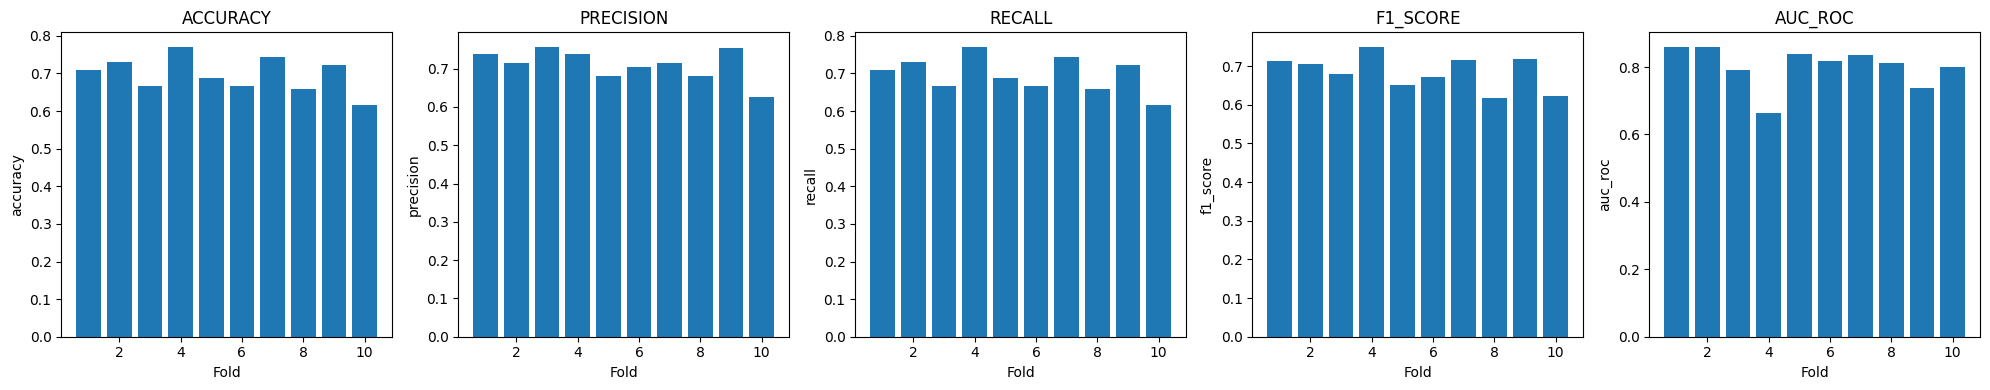

In [34]:
import matplotlib.pyplot as plt
# %%
cv_df = pd.read_csv(os.path.join(results_dir, "crossval_summary.csv"))
metrics = ['accuracy','precision','recall','f1_score','auc_roc']
fig, axs = plt.subplots(1,len(metrics), figsize=(20,4))
for i,m in enumerate(metrics):
    axs[i].bar(cv_df['fold'], cv_df[m]); axs[i].set_title(m.upper()); axs[i].set_xlabel('Fold'); axs[i].set_ylabel(m)
plt.tight_layout(); plt.show()

# ## Step 7: Ensemble Averaging from 10 CV Models


In [36]:
# %%
ess_preds=[]
test_data=torch.load(os.path.join(base_path, f"{task}_test.pt"))
tl=DataLoader(test_data, batch_size=32)
for fold in range(10):
    model = GIN(test_data[0].x.size(1), hidden_channels=best_hidden_dim, out_channels=num_classes, dropout=best_dropout).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval(); outs=[]
    with torch.no_grad():
        for b in tl: outs.append(model(b.to(device)).cpu())
    ess_preds.append(torch.cat(outs,0))
avg=torch.stack(ess_preds).mean(0)
f_pred=avg.argmax(1).numpy(); t_true=torch.cat([d.y for d in test_data]).numpy().astype(int)
pd.DataFrame({'True':t_true,'Pred':f_pred}).to_csv(os.path.join(results_dir,'ensemble_preds.csv'),index=False)
print('✅ Ensemble preds saved')

✅ Ensemble preds saved


# ## Step 7b: Ensemble Model Evaluation – Confusion Matrix & AUC‑ROC


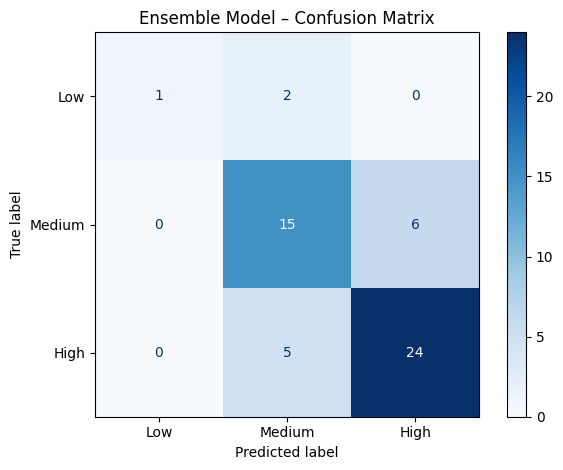

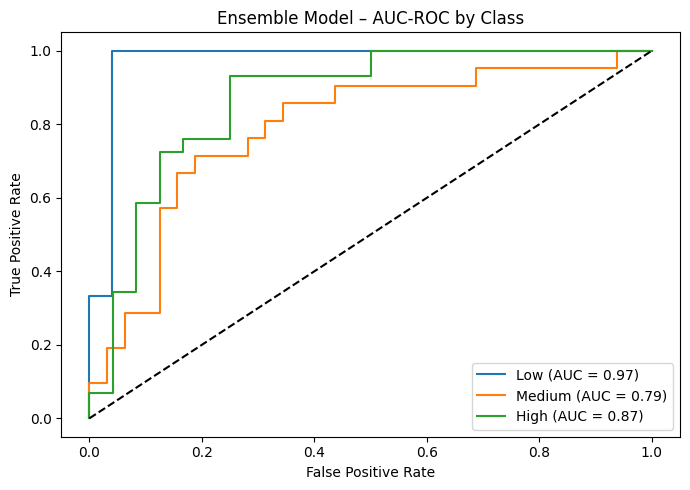

In [39]:

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Load ensemble predictions
ens_df = pd.read_csv(os.path.join(results_dir, 'ensemble_preds.csv'))
y_true_ens = ens_df['True'].values
y_pred_ens = ens_df['Pred'].values

# 1) Confusion matrix
cm = confusion_matrix(y_true_ens, y_pred_ens)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[class_names[i] for i in range(num_classes)])
disp.plot(cmap='Blues')
plt.title("Ensemble Model – Confusion Matrix")
plt.tight_layout()
plt.show()

# 2) AUC‑ROC per class
# Need probability estimates – reload avg_output if available or recompute probabilities
# If you only have hard preds, rerun ensemble loop with model outputs saved as probs:
#     avg_probs = torch.stack(ensemble_prob_lists).mean(0).numpy()
# For now, assuming you have `avg_probs`:
avg_output = avg
y_probs = avg_output.softmax(dim=1).numpy()  # or your stored avg_probs
y_true_bin = label_binarize(y_true_ens, classes=np.arange(num_classes))

plt.figure(figsize=(7,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble Model – AUC‑ROC by Class")
plt.legend()
plt.tight_layout()
plt.show()


# ## Step 8: Final Model Training on Combined Data & Test Evaluation


c:\Users\MIchele Myong\anaconda3\envs\pytorch_env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | Train Loss: 0.8616 | Val Loss: 0.5882 | Best Val Loss: 0.5882 | Patience: 0
Epoch 002 | Train Loss: 0.5589 | Val Loss: 0.4657 | Best Val Loss: 0.4657 | Patience: 0
Epoch 003 | Train Loss: 0.4429 | Val Loss: 0.4439 | Best Val Loss: 0.4439 | Patience: 0
Epoch 004 | Train Loss: 0.3324 | Val Loss: 0.2656 | Best Val Loss: 0.2656 | Patience: 0
Epoch 005 | Train Loss: 0.2772 | Val Loss: 0.3916 | Best Val Loss: 0.2656 | Patience: 1
Epoch 006 | Train Loss: 0.2152 | Val Loss: 0.3778 | Best Val Loss: 0.2656 | Patience: 2
Epoch 007 | Train Loss: 0.1937 | Val Loss: 0.1774 | Best Val Loss: 0.1774 | Patience: 0
Epoch 008 | Train Loss: 0.1537 | Val Loss: 0.1034 | Best Val Loss: 0.1034 | Patience: 0
Epoch 009 | Train Loss: 0.1188 | Val Loss: 0.1016 | Best Val Loss: 0.1016 | Patience: 0
Epoch 010 | Train Loss: 0.0937 | Val Loss: 0.0480 | Best Val Loss: 0.0480 | Patience: 0
Epoch 011 | Train Loss: 0.0615 | Val Loss: 0.0612 | Best Val Loss: 0.0480 | Patience: 1
Epoch 012 | Train Loss: 0.1130 |

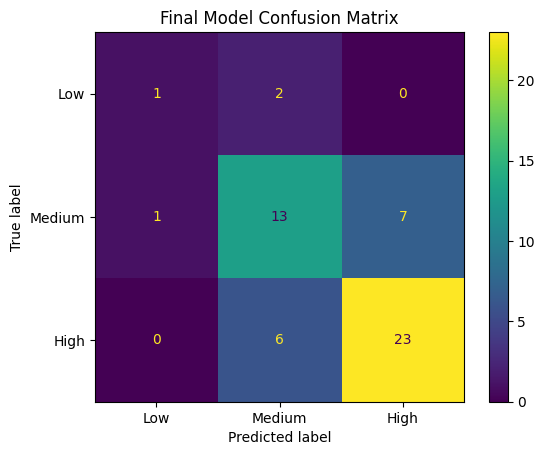

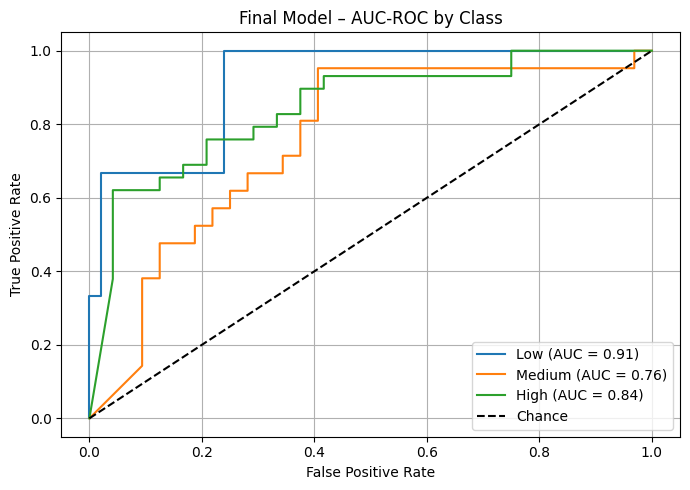

,Accuracy
ensemble,0.754717
final,0.698113


✅ Final metrics saved
✅ Final confusion matrix saved
✅ Final AUC-ROC saved
✅ Final predictions saved


In [42]:

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

# Merge train+val
all_data=[]
for fold in range(10):
    all_data+=torch.load(os.path.join(base_path,f"{task}_train_fold{fold}.pt"))
    all_data+=torch.load(os.path.join(base_path,f"{task}_val_fold{fold}.pt"))
# small val
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=seed)
labels=[int(d.y.item()) for d in all_data]
train_idx,val_idx=next(sss.split(all_data,labels))
train_split=[all_data[i] for i in train_idx]; val_split=[all_data[i] for i in val_idx]
tr=DataLoader(train_split,batch_size=32,shuffle=True,worker_init_fn=seed_worker,generator=generator)
vl=DataLoader(val_split,batch_size=32)
model=GIN(all_data[0].x.size(1),hidden_channels=best_hidden_dim,out_channels=num_classes,dropout=best_dropout).to(device)
opt=torch.optim.Adam(model.parameters(),lr=best_lr)
sched=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',patience=5,factor=0.5,verbose=True)
best_v=1e9;pat=0
for epoch in range(1,101):
    model.train();tot=0
    for b in tr: b=b.to(device);opt.zero_grad();o=model(b);l=F.cross_entropy(o,b.y.long());l.backward();opt.step();tot+=l.item()
    preds,labels=evaluate(model,vl);vloss=F.cross_entropy(preds,labels.long()).item();sched.step(vloss)
    if vloss<best_v:best_v=vloss;pat=0;torch.save(model.state_dict(),os.path.join(results_dir,'final_model.pt'))
    else: pat+=1
    if pat>=10:break
    print(f"Epoch {epoch:03d} | Train Loss: {tot/len(tr):.4f} | Val Loss: {vloss:.4f} | Best Val Loss: {best_v:.4f} | Patience: {pat}")

# test eval
model.load_state_dict(torch.load(os.path.join(results_dir,'final_model.pt')))
td=DataLoader(torch.load(os.path.join(base_path,f"{task}_test.pt")),batch_size=32)
preds,labels=evaluate(model,td);y_pred=preds.argmax(1).numpy();y_true=labels.numpy().astype(int)
# metrics
acc_f=accuracy_score(y_true,y_pred);prec,rec,f1,_=precision_recall_fscore_support(y_true,y_pred,average='weighted')
# confusion
cm=confusion_matrix(y_true,y_pred);disp=ConfusionMatrixDisplay(cm,display_labels=list(class_names.values()));disp.plot()
plt.title('Final Model Confusion Matrix');plt.show()
# final auc
 # Assume y_true is shape (n,) and preds is torch.Tensor of shape (n, num_classes)
probs     = F.softmax(preds, dim=1).cpu().numpy()     # (n, C)
y_true    = labels.numpy().astype(int)                 # (n,)
y_true_bin= label_binarize(y_true, classes=np.arange(num_classes))  # (n, C)

plt.figure(figsize=(7, 5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final Model – AUC‑ROC by Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparison table
ensemble_df=pd.read_csv(os.path.join(results_dir,'ensemble_preds.csv'))
ensemble_acc=accuracy_score(ensemble_df['True'],ensemble_df['Pred'])
final_metrics = {'ensemble': ensemble_acc, 'final': acc_f}
comp = pd.DataFrame.from_dict(final_metrics, orient='index', columns=['Accuracy'])
display(comp)

# Save final metrics
final_metrics = {
    'accuracy': acc_f,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'auc_roc': roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), probs, multi_class='ovr')
}
final_metrics_df = pd.DataFrame(final_metrics, index=[0])
final_metrics_df.to_csv(os.path.join(results_dir, 'final_metrics.csv'), index=False)
print("✅ Final metrics saved")
# Save final confusion matrix
cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())
cm_df.to_csv(os.path.join(results_dir, 'final_confusion_matrix.csv'))
print("✅ Final confusion matrix saved")
# Save final AUC-ROC
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_auc = auc(fpr, tpr)
roc_df.to_csv(os.path.join(results_dir, 'final_auc_roc.csv'), index=False)
print("✅ Final AUC-ROC saved")
# Save final predictions
preds_df = pd.DataFrame({'True': y_true, 'Pred': y_pred})
preds_df.to_csv(os.path.join(results_dir, 'final_predictions.csv'), index=False)
print("✅ Final predictions saved")


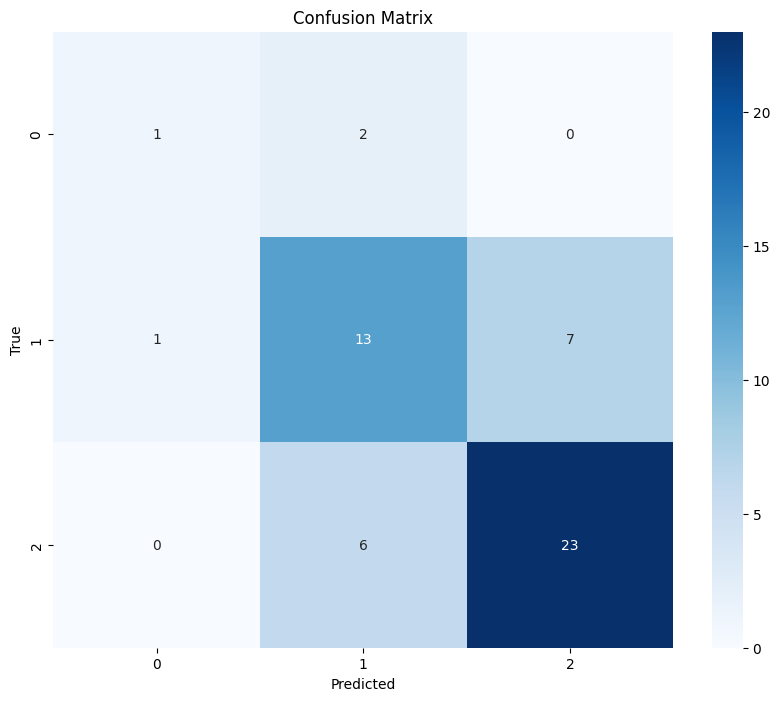

In [43]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot confusion matrix 
if task == "classification":
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
